In [35]:
# importing the required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

### Paths for the dataset, model, tflite

In [36]:
# Dataset
dataset = 'modelc/keypoint_classifier/keypoint.csv'
# model save path
model_save_path = 'modelc/keypoint_classifier/keypoint_classifier.hdf5'
# tflite save path
tflite_save_path = 'modelc/keypoint_classifier/keypoint_classifier.tflite'

### Setting the number of classes 

In [37]:
# if necessary this training classes can be changed
NUM_CLASSES = 19
RANDOM_SEED = 42

### Reading the dataset

In [38]:
x_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [39]:
# spliting the dataset into training and testing sets
# where training is 75% of the dataset and testing is 25%
# seperating is done randomly selection of the available datasets
x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, train_size=0.75, random_state = RANDOM_SEED)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18]), array([ 939,  955, 1756, 1010,  961, 3165, 1818, 1430, 1920, 1410, 1167,
       1401, 3044, 2022, 1510,  164,  257,  139,  190], dtype=int64))


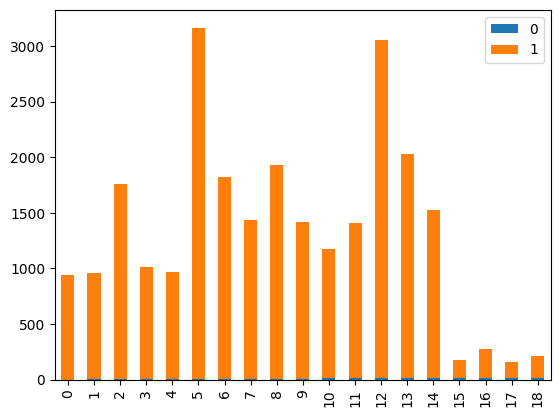

In [40]:
# count of the classes
counts = np.unique(y_dataset, return_counts = True)
df = pd.DataFrame(counts)
df.T.plot(kind='bar', stacked=True)
print(counts)

### Building of the Model

In [41]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.03),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dropout(0.03),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.03),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [42]:
# Summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_3 (Dropout)         (None, 42)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                1376      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 19)               

In [43]:
# Model checkpoint and callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path,
    verbose = 1,
    save_weights_only = False,
    save_best_only = True
)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(
    patience = 250,
    verbose = 1
)

In [44]:
# Model Compilation
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'], 
)

### Model Training

In [45]:
model.fit(
    x_train,
    y_train,
    epochs = 1000,
    batch_size = 64,
    validation_data = (x_test, y_test),
    callbacks=[cp_callback, es_callback],
)

Epoch 1/1000


284/296 [===========================>..] - ETA: 0s - loss: 2.0538 - accuracy: 0.3667
Epoch 1: val_loss improved from inf to 1.15398, saving model to modelc/keypoint_classifier\keypoint_classifier.hdf5
296/296 [==============================] - 3s 4ms/step - loss: 2.0236 - accuracy: 0.3761 - val_loss: 1.1540 - val_accuracy: 0.6926
Epoch 2/1000
295/296 [============================>.] - ETA: 0s - loss: 1.0151 - accuracy: 0.6804
Epoch 2: val_loss improved from 1.15398 to 0.63274, saving model to modelc/keypoint_classifier\keypoint_classifier.hdf5
296/296 [==============================] - 1s 3ms/step - loss: 1.0138 - accuracy: 0.6807 - val_loss: 0.6327 - val_accuracy: 0.8059
Epoch 3/1000
291/296 [============================>.] - ETA: 0s - loss: 0.7707 - accuracy: 0.7498
Epoch 3: val_loss improved from 0.63274 to 0.45835, saving model to modelc/keypoint_classifier\keypoint_classifier.hdf5
296/296 [==============================] - 1s 3ms/step - loss: 0.7695 - accuracy: 0.7503 - val_loss: 

In [46]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [47]:
val_loss, val_accuracy = model.evaluate(x_test, y_test, batch_size = 64)

99/99 [==============================] - 0s 1ms/step - loss: 0.0132 - accuracy: 0.9965


In [48]:
# Inference Test
predict_result = model.predict(np.array([x_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 178ms/step
[1.0523216e-06 5.6727085e-09 1.6900069e-06 1.7324706e-11 2.6924929e-09
 9.9998593e-01 2.9968749e-07 2.5843536e-15 4.2877750e-11 2.2284926e-20
 3.4866818e-11 3.6493451e-18 1.0969731e-05 3.4982821e-09 3.2359949e-08
 4.2625308e-18 1.7757645e-12 1.1731418e-28 7.0406395e-16]
5


### Convert the model to Tensorflow-Lite

In [49]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer = False)

In [50]:
# Transform model (quantization)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()
open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Hi\AppData\Local\Temp\tmpj3u3ex9l\assets


INFO:tensorflow:Assets written to: C:\Users\Hi\AppData\Local\Temp\tmpj3u3ex9l\assets


8696